
# Kick-off Notebook  
[COMP20121 Machine Learning for Data Analytics](https://sites.google.com/site/hejunhomepage/Teaching/machine-learning-for-data-analytics)

Author: Jun He

* This notebook aims to help you kick off your coursework. 
* **Warning: the coursework is an individual work, and you should implement it independently. You may refer to the kick-off notebook and other notebooks. but you must ensure code similarity less than than 50%. Otherwise, it will be punished.** 


### Load data
* The link to the data is https://www.kaggle.com/c/kaggle-survey-2021/data
* Visit the website and read two supplementary files `kaggle_survey_2021_methodology.pdf` and `kaggle_survey_2021_answer_choices.pdf` for understanding the survey questions 
* Upload the data set `kaggle_survey_2021_responses.csv` to your Kaggle account
* You must understand the data  before you start your coursework. 
 

In [ ]:
import pandas as pd 
survey = pd.read_csv("../input/kaggle-survey-2021/kaggle_survey_2021_responses.csv")   
survey

### Data cleaning: unrelated data 
* The first row describes  questions but not data
* We remove the first row

In [ ]:
survey = survey.iloc[1: , :]
survey

#### Create a dataframe with Country, Income
* In this kick-off notebook, only one predictors `Country` and the target variable `Income` are selected in data analysis.
* Note: for this data, a feature corresponds to a survey question in`kaggle_survey_2021_answer_choices.pdf`, which might correspond to several columns in the data set `kaggle_survey_2021_responses.csv`
* We aim to discover the relationship between `Country` and `Income` 
>  Note: you must select more features in your coursewrok
  

In [ ]:
df = pd.DataFrame(columns=['Country','Income'])
df['Country'] = survey['Q3']
df['Income'] = survey['Q25']   
df 

#### EDA: respondents in each country
* Visualize respondents in each country using a choropleth map: https://plotly.com/python/choropleth-maps/
* Note: this map is not taught in our lectures. For a higher 1st class grade, you need to show excellent use of sources that evidence independent study and, in some cases, content that is not taught. 
 

In [ ]:
import plotly.graph_objects as go
countries = df['Country'].value_counts()


fig = go.Figure(data=go.Choropleth(
    locations = countries.index, 
    z = countries,
    locationmode = 'country names',    
))
fig.show()

### Data cleaning: missing values
* Drop all rows with missing values in Column `Income`
* This method is easy but not the best option

In [ ]:
df_clean = df.dropna(subset=['Income'])  
df_clean

### EDA: Income
* Visualize the distribution of `Income`. 

* The figure is not good becuase the order of income is messy.

In [ ]:
import seaborn as sns
sns.countplot(y='Income', data=df_clean)

### Data Preprocessing: Income in Order
* Encode the ordinal data `Income` into levels 

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
income_level_order = [['$0-999',
                        '1,000-1,999',
                        '2,000-2,999',
                        '3,000-3,999',
                        '4,000-4,999',
                        '5,000-7,499',
                        '7,500-9,999',
                        '10,000-14,999',
                        '15,000-19,999',
                        '20,000-24,999',
                        '25,000-29,999',
                        '30,000-39,999',
                        '40,000-49,999',
                        '50,000-59,999',
                        '60,000-69,999',
                        '70,000-79,999',
                        '80,000-89,999',
                        '90,000-99,999',
                        '100,000-124,999',
                        '125,000-149,999',
                        '150,000-199,999',
                        '200,000-249,999',
                        '250,000-299,999',
                        '300,000-499,999',
                        '$500,000-999,999',
                        '>$1,000,000']] 
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(categories = income_level_order) # create an encoder with order
df_clean['IncomeLevel'] = encoder.fit_transform(df_clean['Income'].values.reshape(-1, 1)) # fit encoder with the column edu_level but only this column
df_clean

### EDA: `Income`
* Visualize `Income` in levels. The figure is better


In [ ]:
sns.countplot(y='IncomeLevel', data=df_clean) 

### Data Preprocessing: income in high and low
* Create low and high income: low income if y < 16, otherwise high income.

> Question: Level 16 = how much income?

In [ ]:
df_clean['HighIncome'] = df_clean['IncomeLevel'].apply(lambda x:0 if x < 16 else 1)
df_clean

### EDA:  relation between Country and High Income
* Use crosstab and bar plot 

> Q: The figure is ungly due to many countries. How to reduce the number of countries and only select these with most responses?


In [ ]:
from matplotlib import pyplot as plt
crosstab = pd.crosstab(df_clean["Country"],df_clean['HighIncome'], normalize=True)
crosstab.plot(kind = 'bar', stacked = 'true',grid='true')
plt.show() 

* Select top  countries with most response
 

In [ ]:
top_countries = df_clean['Country'].value_counts().head(5)
print(top_countries.index)
 

* Add a column called `TopCountry`

In [ ]:
def select_countries(x):
    if x  in top_countries.index:
        x = x 
    else:
        x = "rest countries"
    return x
   
#df2['Country'] = df2['Country'].astype(str)
df_clean['TopCountry'] = df_clean['Country'].apply(lambda x: select_countries(x))
df_clean

> Q:  what is your finding? 

In [ ]:
crosstab = pd.crosstab(df_clean["TopCountry"],df_clean['HighIncome'], normalize=True)
crosstab.plot(kind = 'bar', stacked = 'true',grid='true')
plt.show() 

### Clustering: split samples into low and high income groups
* Group data by low and high`Income`
* Low income group is `group(0)` 
> Note:  we only select two features `'TopCountry','HighIncome'`  for clustering. But the feature  `'HighIncome'` does not affect clustering because its value always is 0 in low income group and 1 in high inclome group.  

In [ ]:
grouped = df_clean[['TopCountry','HighIncome']].groupby('HighIncome')  #group data into low and high incomes
df_low = pd.DataFrame(grouped.get_group(0), columns=['TopCountry','HighIncome']) # 0 for low income
df_low

In [ ]:
df_high = pd.DataFrame(grouped.get_group(1), columns=['TopCountry','HighIncome']) # 1 for high income
df_high

### Clustering: Cluster low income people and Understand characteristics of clusters  
* Cluster low income people
> Note: I set k=3. But this might be not the best choice. You may find the best value of k using elbow or silhouette methods

In [ ]:
from sklearn.cluster import KMeans
X_low = pd.get_dummies(df_low) #OneHot Encoding.  
km = KMeans(n_clusters=3)  
y_low = km.fit_predict(X_low) # labels of sample
df_low['Cluster']=y_low
df_low

* Visualize the clusters
> Note: describe charactersitics of each low income cluster. 

In [ ]:
import matplotlib.pyplot as plt
churn_crosstab = pd.crosstab(df_low['Cluster'],df_low["TopCountry"],  normalize=True)
churn_crosstab.plot(kind = 'bar', grid=True,fontsize=15)
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.show()

### Clustering: Cluster high income people and Understand characteristics of clusters  
* Cluster high income people 
* Visualize the clusters
> Note: describe charactersitics of each high income cluster. 

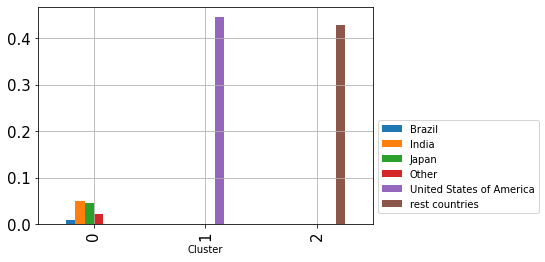

### Classification
* Build different models for classification. 
> Note: for an example, a decision tree. 

In [ ]:
from sklearn import tree 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
X = df_clean[['TopCountry']] #set the predictor
y = df_clean['HighIncome'] #set the target
X = pd.get_dummies(X) #encode countries
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #split
dt = tree.DecisionTreeClassifier( max_depth = 1, random_state=1)  #build decision tree
dt = dt.fit(X_train, y_train) #fit decision tree
y_pred = dt.predict(X_test)
print ("Accuracy: {0:.3f}".format(metrics.accuracy_score(y_test, y_pred)),"\n") 
fig = plt.figure()
_ = tree.plot_tree(dt, feature_names=X.columns, class_names=["Low", "High"], filled=True)

### Kick-off your own work
* Add more features  such as education, programming language, platform, programming years. 
* Implement more data analyses such as EDA, classification and clustering 